# Unlocking Business Potential: Leveraging Bias-Aware Hierarchical Clustering for Actionable Insights from Yelp Data

### Zeinab Gaeini, Debbie Hernandez, Harper Strickland

## Part 4 - Analysis

### In-depth investigation of Selected Clusters, Leading to Specific Recommendations for Businesses

In this file, we will analyze the results of the clustering from the previous step. We will use the Top_Clusters.csv file, normalized business data (restaurants), normalized features (attributes of restaurants), and Reviews datasets. The goal is to conduct an in-depth analysis to provide specific recommendations for business owners.

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import round as pyspark_round
from pyspark.sql.functions import lower, split, explode, col, regexp_replace, trim
from pyspark.sql.types import FloatType, StringType, StructType, StructField
import matplotlib.pyplot as plt 


In [2]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [3]:
# make a directory on hdfs (repeated in case this notebook is used alone)
! hdfs dfs -mkdir /Project/

In [4]:
# copy files to hdfs (include repeats in case notebook used alone)
! hdfs dfs -copyFromLocal yelp_academic_dataset_business.json /Project
! hdfs dfs -copyFromLocal yelp_academic_dataset_review.json /Project
! hdfs dfs -copyFromLocal Features.csv /Project
! hdfs dfs -copyFromLocal Data.csv /Project
! hdfs dfs -copyFromLocal Top_Clusters.csv /Project

In [ ]:
! hdfs dfs -ls /Project

In [4]:
# Start Spark Session
conf = pyspark.SparkConf().setAll([
        ('spark.master',   'local[*]'),
        ('spark.app.name', 'Analysis')])

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.version

'3.5.0'

## 4.1. Inputs

#### 4.1.1. Import Data Files

In [5]:
# Read data of Top Clusters (output of the clustering phase)
clusters = spark.read.csv('hdfs:///Project/Top_Clusters.csv', header = True)


In [6]:
clusters.filter((clusters['Cluster_Name'] == 'Worst_1')).show(5)

+------------+-------+-------+--------------------+
|Cluster_Name|K_Value|Cluster|         Business_ID|
+------------+-------+-------+--------------------+
|     Worst_1|   1000|    558|q8b9QZuB-s6mwr4E5...|
|     Worst_1|   1000|    558|6kx5nIZh9bQ_02_GO...|
|     Worst_1|   1000|    558|b0hSNSvD2evs_DEl8...|
|     Worst_1|   1000|    558|W55GtTcl8tv564IZ1...|
|     Worst_1|   1000|    558|XGy_KnoOX9Wkyjx8u...|
+------------+-------+-------+--------------------+
only showing top 5 rows



In [7]:
# Read the business data (the selected subset of businesses)
businessDF = spark.read.csv('hdfs:///Project/Data.csv', header = True)
# Read the review data
reviewDF = spark.read.json('hdfs:///Project/yelp_academic_dataset_review.json')
# Read the normalized business 
norm_business = spark.read.csv('hdfs:///Project/Features.csv', header = True)


#### 4.1.2. Merge DataFrames

In [8]:
# Join with Business data frame
cluster_business = clusters.join(businessDF, on = 'business_id', how = 'left')
    
# Join with Review data frame
cluster_review = clusters.join(reviewDF, on = 'business_id', how = 'left')
    
# Join with normalized business data frame
cluster_norm = clusters.join(norm_business, on = 'business_id', how = 'left')


In [9]:
# Compute the number of unique clusters
len_cluster = cluster_norm.select('Cluster').distinct().count()  
    
# Make a list of clusters 
cluster_list = [cluster_norm.select('Cluster_Name').distinct().collect()[i][0] for i in range(len_cluster)]
cluster_list.sort()


In [10]:
cluster_list

['Best_1',
 'Best_2',
 'Best_3',
 'Best_4',
 'Worst_1',
 'Worst_2',
 'Worst_3',
 'Worst_4']

## 4.2. Overview - All 'Best' and 'Worst' Clusters

#### 4.1.1. Define Functions to Compare Clusters

In [11]:
# Define a function to compare the characteristics of selected clusters and the main dataframe with all the data

def compare(first_df, column, second_df):
    first_df.cache()
    first_df = first_df.withColumn(column, first_df[column].cast(FloatType()))  # Make sure about type to be float
    second_df = second_df.withColumn(column, second_df[column].cast(FloatType()))
    
    # Compute the number of unique clusters
    len_cluster = first_df.select('Cluster_Name').distinct().count()  
    
    # Make a list of clusters 
    cluster_list = [first_df.select('Cluster_Name').distinct().collect()[i][0] for i in range(len_cluster)]
 
    data = []
    for i in range(len_cluster):
        cluster_stats = (
            f'{cluster_list[i]}',
            first_df.groupBy('Cluster_Name').agg({column: "variance"}).collect()[i][1],
            first_df.groupBy('Cluster_Name').agg({column: "min"}).collect()[i][1],
            first_df.groupBy('Cluster_Name').agg({column: "max"}).collect()[i][1],
            first_df.groupBy('Cluster_Name').agg({column: "mean"}).collect()[i][1]
        )
        data.append(cluster_stats)

    # Column names
    columns_name = ['Source', 'Variance', 'Min', 'Max', 'Mean']

    # DataFrame
    new_df = spark.createDataFrame(data, columns_name)
    
    list_col = [ 'Variance', 'Min', 'Max', 'Mean']
    for column in list_col:
        new_df = new_df.withColumn(column, pyspark_round(col(column).cast("float"),3))
        
    new_df = new_df.orderBy('Source')    
    return new_df


In [12]:
def overview():
    # Compare all clusters - stars
    print('Clusters Overview: Stars')
    compare(cluster_business, 'stars', norm_business).show()
    
    # Compare all clusters - review count
    print('Clusters Overview: Review Count')
    compare(cluster_business, 'review_count', businessDF).show()


#### 4.1.2. Compare Clusters

In [13]:
# Take a look at the rating values and review counts for each cluster
overview()


Clusters Overview: Stars


+-------+--------+---+---+-----+
| Source|Variance|Min|Max| Mean|
+-------+--------+---+---+-----+
| Best_1|   0.281|3.0|5.0|4.363|
| Best_2|   0.312|3.0|5.0|4.323|
| Best_3|    0.52|2.0|5.0|4.314|
| Best_4|   0.345|2.5|5.0|4.295|
|Worst_1|   0.279|1.0|3.5|1.877|
|Worst_2|   0.463|1.0|4.0|1.982|
|Worst_3|    0.38|1.0|3.5|1.991|
|Worst_4|    0.44|1.0|3.5|  2.0|
+-------+--------+---+---+-----+

Clusters Overview: Review Count
+-------+--------+---+-----+------+
| Source|Variance|Min|  Max|  Mean|
+-------+--------+---+-----+------+
| Best_1|2816.372|5.0|240.0|62.294|
| Best_2|2063.852|5.0|234.0|43.129|
| Best_3| 990.667|5.0|171.0|25.333|
| Best_4| 646.692|5.0|152.0|23.882|
|Worst_1| 180.884|5.0| 74.0|21.614|
|Worst_2| 211.143|7.0| 84.0|25.509|
|Worst_3| 122.829|5.0| 51.0|19.547|
|Worst_4| 181.474|7.0| 84.0|24.745|
+-------+--------+---+-----+------+



The results in these two tables, comparing **ratings** (number of stars) and **review counts** for businesses:

- Stars:
    - The top 4 clusters have better ratings, with an average of more than 4 stars in the Good clusters.
    - Ratings in the Bad clusters are lower, with averages ranging between 1 and 3 stars.

- Review Counts:
    - The maximum number of reviews in the Good clusters is significantly higher than in the Bad clusters.
    - In most cases, the average number of reviews in the Good clusters is higher than in the Bad clusters.

## 4.3 Cluster-Level Analysis

#### 4.3.1. Define Functions to analyze a single cluster

In [14]:
# Define a function to remove extra characters (from PA2 Starter)
def removePunctuation(column):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces."""
    return trim(lower(regexp_replace(column, "[^A-Za-z0-9 ]", ""))).alias("sentence")


In [15]:
def cl_word_count (name):
    cluster_rev = cluster_review.filter(col('Cluster_Name') == name)
    review_text = cluster_rev.select('text')
    
    #Remove punctuation
    review_text = review_text.withColumn('sentence', removePunctuation(review_text.text))
    
    #Split-explode into words
    wordDF = review_text.select(explode(split(review_text.sentence, ' ')).alias('word'))
    
    # Remove blank rows
    wordDF = wordDF.filter(wordDF.word != '') 
    word_total = wordDF.count()
    word_count = wordDF.count() / cluster_rev.count()
    return word_count


In [16]:
# Combine into cluster_details function
def cl_details (name):
    print('Cluster_Name', name)
    cluster_pandas = cluster_norm.filter(cluster_norm['Cluster_Name'] == name).select('stars').toPandas().sort_values(by = 'stars')

    # Plot distribution of stars
    plt.figure(figsize=(8, 6))
    cluster_pandas['stars'].hist(bins=7, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Number of Stars')
    plt.xlabel('Stars')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()
    
    # Show categories
    cluster_bus = cluster_business.filter(col('Cluster_Name') == name)
    cat_num = cluster_bus.select(split(cluster_bus["categories"], ', ').alias('cat')) \
                        .select(explode('cat').alias('Category')) \
                        .groupBy('Category').count()
    x = cluster_bus.count()
    
    # Calculate the percentage of each category
    
    cat_num = cat_num.withColumn('Percent', pyspark_round(cat_num['count'] / x * 100, 3))
    
    # Order by count in descending order and show the top 10 categories
    cat_num_top = cat_num.orderBy('count', ascending=False).limit(10)
    print(f"Top Categories for Cluster {name}:")
    cat_num_top.show(truncate=False)
    
    # Show attributes statistics 
    one_cluster_norm = cluster_norm.filter(col('Cluster_Name') == name)
    norm_cols = one_cluster_norm.columns[5:]
    data = []
    for i in range(len(norm_cols)):
        att_stats = (
            norm_cols[i],
            one_cluster_norm.groupBy('Cluster').agg({norm_cols[i]: "variance"}).collect()[0][1],
            one_cluster_norm.groupBy('Cluster').agg({norm_cols[i]: "min"}).collect()[0][1],
            one_cluster_norm.groupBy('Cluster').agg({norm_cols[i]: "max"}).collect()[0][1],
            one_cluster_norm.groupBy('Cluster').agg({norm_cols[i]: "mean"}).collect()[0][1]
        )
        data.append(att_stats)
        
        
    columns_name = ['Feature', '  Variance ', '  Min  ', '  Max  ', '   Mean   ']
    new_df = spark.createDataFrame(data, columns_name)
    
    
    list_col = [ '  Variance ', '  Min  ', '  Max  ', '   Mean   ']
    for column in list_col:
        new_df = new_df.withColumn(column, pyspark_round(col(column).cast("float"),3))
    
    new_df.orderBy('   Mean   ', ascending = False).show(new_df.count(), truncate=False)
    
    
    # Average word count for reviews
    wc = cl_word_count(name)
    print('Average words per review:', wc)
    

#### 4.3.2. Analyze individual clusters

Cluster_Name Best_1


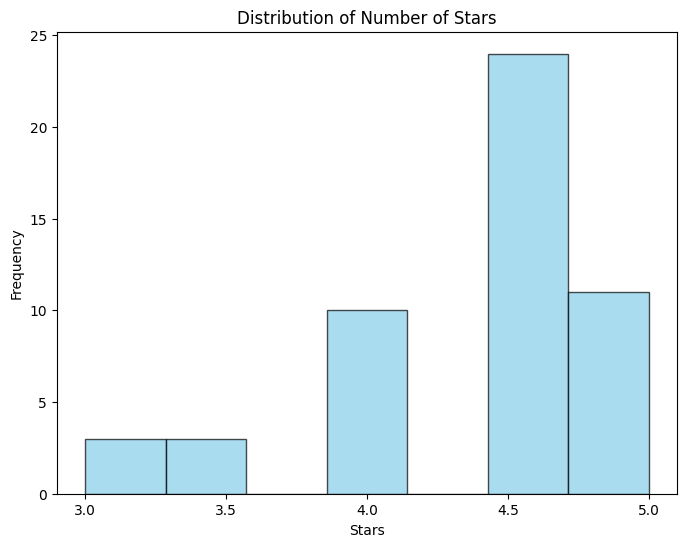

Top Categories for Cluster Best_1:
+----------------------+-----+-------+
|Category              |count|Percent|
+----------------------+-----+-------+
|Restaurants           |51   |100.0  |
|Food                  |45   |88.235 |
|Coffee & Tea          |35   |68.627 |
|Cafes                 |27   |52.941 |
|Coffee Roasteries     |15   |29.412 |
|Breakfast & Brunch    |13   |25.49  |
|Juice Bars & Smoothies|10   |19.608 |
|Bakeries              |7    |13.725 |
|Sandwiches            |6    |11.765 |
|Desserts              |6    |11.765 |
+----------------------+-----+-------+

+--------------------------+-----------+-------+-------+----------+
|Feature                   |  Variance |  Min  |  Max  |   Mean   |
+--------------------------+-----------+-------+-------+----------+
|WheelchairAccessible      |0.0        |1.0    |1.0    |1.0       |
|BusinessAcceptsCreditCards|0.0        |1.0    |1.0    |1.0       |
|BusinessParking_street    |0.02       |0.0    |1.0    |0.98      |
|BikeParki

Average words per review: 82.90189486552568


In [17]:
cl_details('Best_1')

**For businesses in the same category as the Best_1 cluster, which includes Food, Coffee & Tea, and Breakfast & Brunch, we recommend prioritizing the following attributes based on this cluster's top features:**

- Takeout options
- Space for dogs

Cluster_Name Best_2


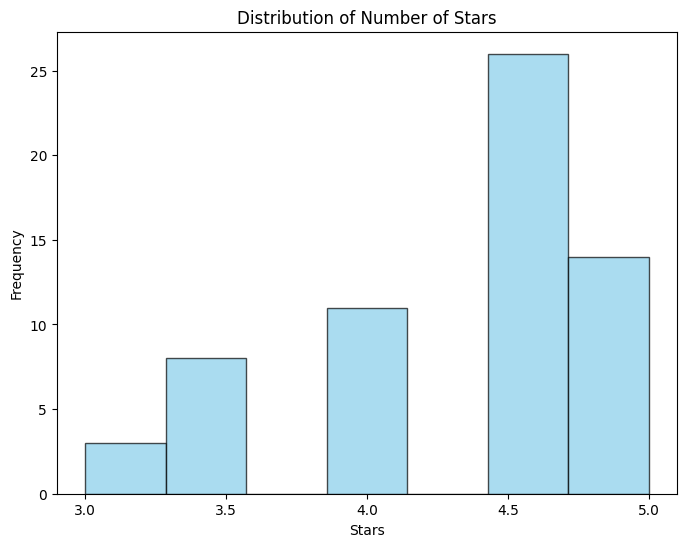

Top Categories for Cluster Best_2:
+----------------------+-----+-------+
|Category              |count|Percent|
+----------------------+-----+-------+
|Restaurants           |62   |100.0  |
|Food                  |35   |56.452 |
|Coffee & Tea          |17   |27.419 |
|Breakfast & Brunch    |16   |25.806 |
|Sandwiches            |12   |19.355 |
|Desserts              |9    |14.516 |
|Mexican               |7    |11.29  |
|Juice Bars & Smoothies|6    |9.677  |
|Bakeries              |6    |9.677  |
|Chinese               |6    |9.677  |
+----------------------+-----+-------+



+--------------------------+-----------+-------+-------+----------+
|Feature                   |  Variance |  Min  |  Max  |   Mean   |
+--------------------------+-----------+-------+-------+----------+
|RestaurantsTableService   |0.0        |1.0    |1.0    |1.0       |
|BusinessAcceptsCreditCards|0.0        |1.0    |1.0    |1.0       |
|WheelchairAccessible      |0.016      |0.0    |1.0    |0.984     |
|RestaurantsTakeOut        |0.032      |0.0    |1.0    |0.968     |
|Caters                    |0.061      |0.0    |1.0    |0.935     |
|RestaurantsDelivery       |0.075      |0.0    |1.0    |0.919     |
|WiFi                      |0.075      |0.0    |1.0    |0.919     |
|OutdoorSeating            |0.178      |0.0    |1.0    |0.774     |
|BikeParking               |0.216      |0.0    |1.0    |0.694     |
|BusinessParking_lot       |0.233      |0.0    |1.0    |0.645     |
|RestaurantsPriceRange2    |0.021      |0.0    |0.5    |0.416     |
|NoiseLevel                |0.005      |0.0    |

Average words per review: 88.08384754990925


In [18]:
cl_details('Best_2')

**In the second Good Cluster, businesses in similar categories such as Food, and Breakfast & Brunch, should focus more on providing ample parking space and maintaining a reasonable price range.**

Cluster_Name Worst_1


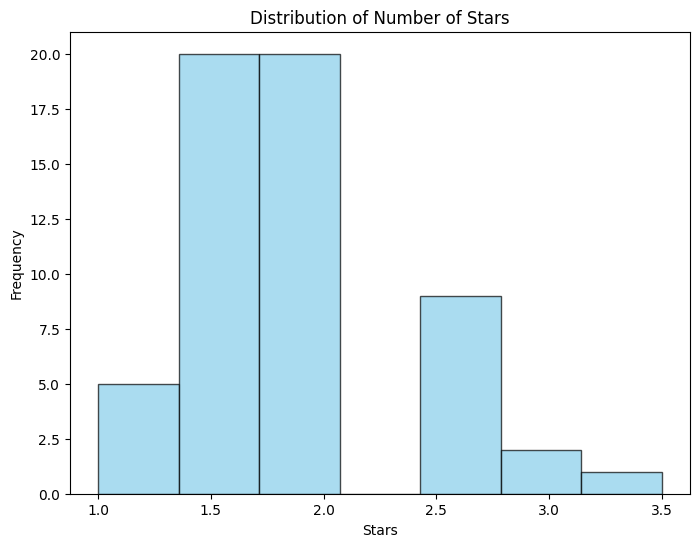

Top Categories for Cluster Worst_1:
+------------------+-----+-------+
|Category          |count|Percent|
+------------------+-----+-------+
|Fast Food         |57   |100.0  |
|Restaurants       |57   |100.0  |
|Burgers           |48   |84.211 |
|Mexican           |43   |75.439 |
|Tacos             |43   |75.439 |
|Breakfast & Brunch|42   |73.684 |
|Tex-Mex           |6    |10.526 |
|American (New)    |3    |5.263  |
|Food              |3    |5.263  |
|Chicken Wings     |2    |3.509  |
+------------------+-----+-------+



+--------------------------+-----------+-------+-------+----------+
|Feature                   |  Variance |  Min  |  Max  |   Mean   |
+--------------------------+-----------+-------+-------+----------+
|BusinessAcceptsCreditCards|0.0        |1.0    |1.0    |1.0       |
|DriveThru                 |0.0        |1.0    |1.0    |1.0       |
|GoodForKids               |0.018      |0.0    |1.0    |0.982     |
|RestaurantsDelivery       |0.034      |0.0    |1.0    |0.965     |
|RestaurantsGoodForGroups  |0.123      |0.0    |1.0    |0.86      |
|HasTV                     |0.213      |0.0    |1.0    |0.702     |
|BusinessParking_lot       |0.251      |0.0    |1.0    |0.561     |
|NoiseLevel                |0.021      |0.0    |0.67   |0.302     |
|OutdoorSeating            |0.066      |0.0    |1.0    |0.07      |
|Ambience_casual           |0.034      |0.0    |1.0    |0.035     |
|Caters                    |0.018      |0.0    |1.0    |0.018     |
|GoodForMeal_brunch        |0.018      |0.0    |

Average words per review: 90.20964039785768


In [19]:
cl_details('Worst_1')

Cluster_Name Worst_2


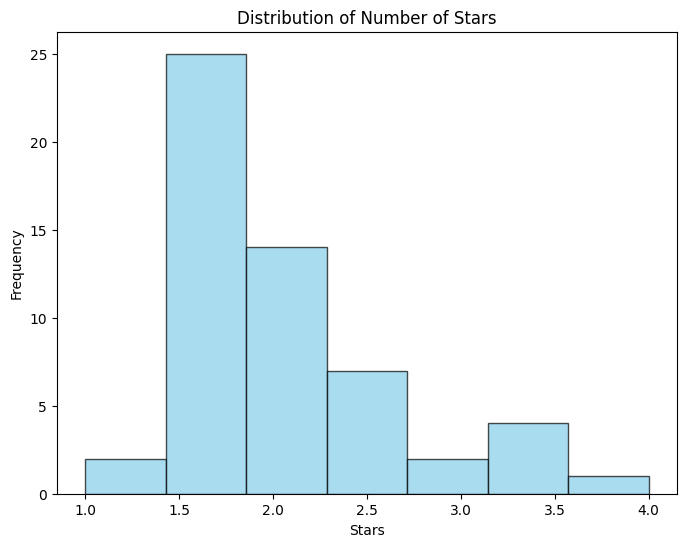

Top Categories for Cluster Worst_2:
+------------------+-----+-------+
|Category          |count|Percent|
+------------------+-----+-------+
|Fast Food         |55   |100.0  |
|Restaurants       |55   |100.0  |
|Burgers           |44   |80.0   |
|Food              |39   |70.909 |
|Coffee & Tea      |39   |70.909 |
|Mexican           |7    |12.727 |
|Tacos             |7    |12.727 |
|Breakfast & Brunch|7    |12.727 |
|Tex-Mex           |7    |12.727 |
|Chicken Wings     |2    |3.636  |
+------------------+-----+-------+

+--------------------------+-----------+-------+-------+----------+
|Feature                   |  Variance |  Min  |  Max  |   Mean   |
+--------------------------+-----------+-------+-------+----------+
|BusinessParking_lot       |0.0        |1.0    |1.0    |1.0       |
|RestaurantsGoodForGroups  |0.0        |1.0    |1.0    |1.0       |
|HasTV                     |0.0        |1.0    |1.0    |1.0       |
|RestaurantsTakeOut        |0.0        |1.0    |1.0    |1.0      

Average words per review: 84.46273712737127


In [20]:
cl_details('Worst_2')

**From the results for the two worst clusters. For businesses in the Fast Food or Burger category, it is recommended to avoid allocating resources to the following attributes:**

- TV
- WiFi
- Accommodating Groups


#### End Spark Session

In [21]:
# End Spark Session
spark.stop()



**For future work:**
- Exploring More Clusters:
    - Different subsets of businesses, categories
    - Additional features: normalized lat/long, other available business details
    - Plotting cluster comparisons
    - Feature variance, primary component analysis
- Validation:
    - Train/test split
    - Regression 
- Detailed Text Analysis:
    - Complexity & structure of reviews
    - Extract features from review text using NLP techniques (sentiment analysis, topic modeling, keyword extraction)
- Geospatial Analysis:
    - Find location-based patterns through clustering
    - Integrate external data sources (demographic information, neighborhood safety scores, proximity to points of interest)
